In [1]:
import pandas as pd
import seaborn as sns
from compress_pickle import dump, load
from math import log
from scipy.stats import kstest
path = './files/'


In [2]:
# function to load pickle files
def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

In [3]:
# import clustering results
# /clustering_results/leiden_2_15_0001_05_msigdb_c2_cgp.gz
# /clustering_results/leiden_2_15_0001_05_msigdb_c3_cgp.gz
# /clustering_results/leiden_2_15_0001_05_msigdb_c6_cgp.gz

msigdb_c2_cgp_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c2_cgp.gz')
# msigdb_c3_tft_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c3_tft.gz')
# msigdb_c6_all_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c6_all.gz')

In [54]:
threshold = 0.05

def get_cluster_distributions(clust_df, filt=False):
    distributions = pd.DataFrame()
    for (res, betas) in clust_df.items():
        for (beta, cluster_enrichments) in betas.items():
            if filt:
                cluster_sizes = [float(log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if ((cluster[0]['FDR'] < threshold).any())]
            else:
                cluster_sizes = [float(log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if cluster[1] > 1]
                
            n_clusters = len(cluster_sizes)
            distributions = pd.concat([distributions, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters, 'beta': [beta]*n_clusters})])
    return distributions

to_get = msigdb_c2_cgp_clust
distributions_df = get_cluster_distributions(to_get, filt=False)
distributions_df_filt = get_cluster_distributions(to_get, filt=True)

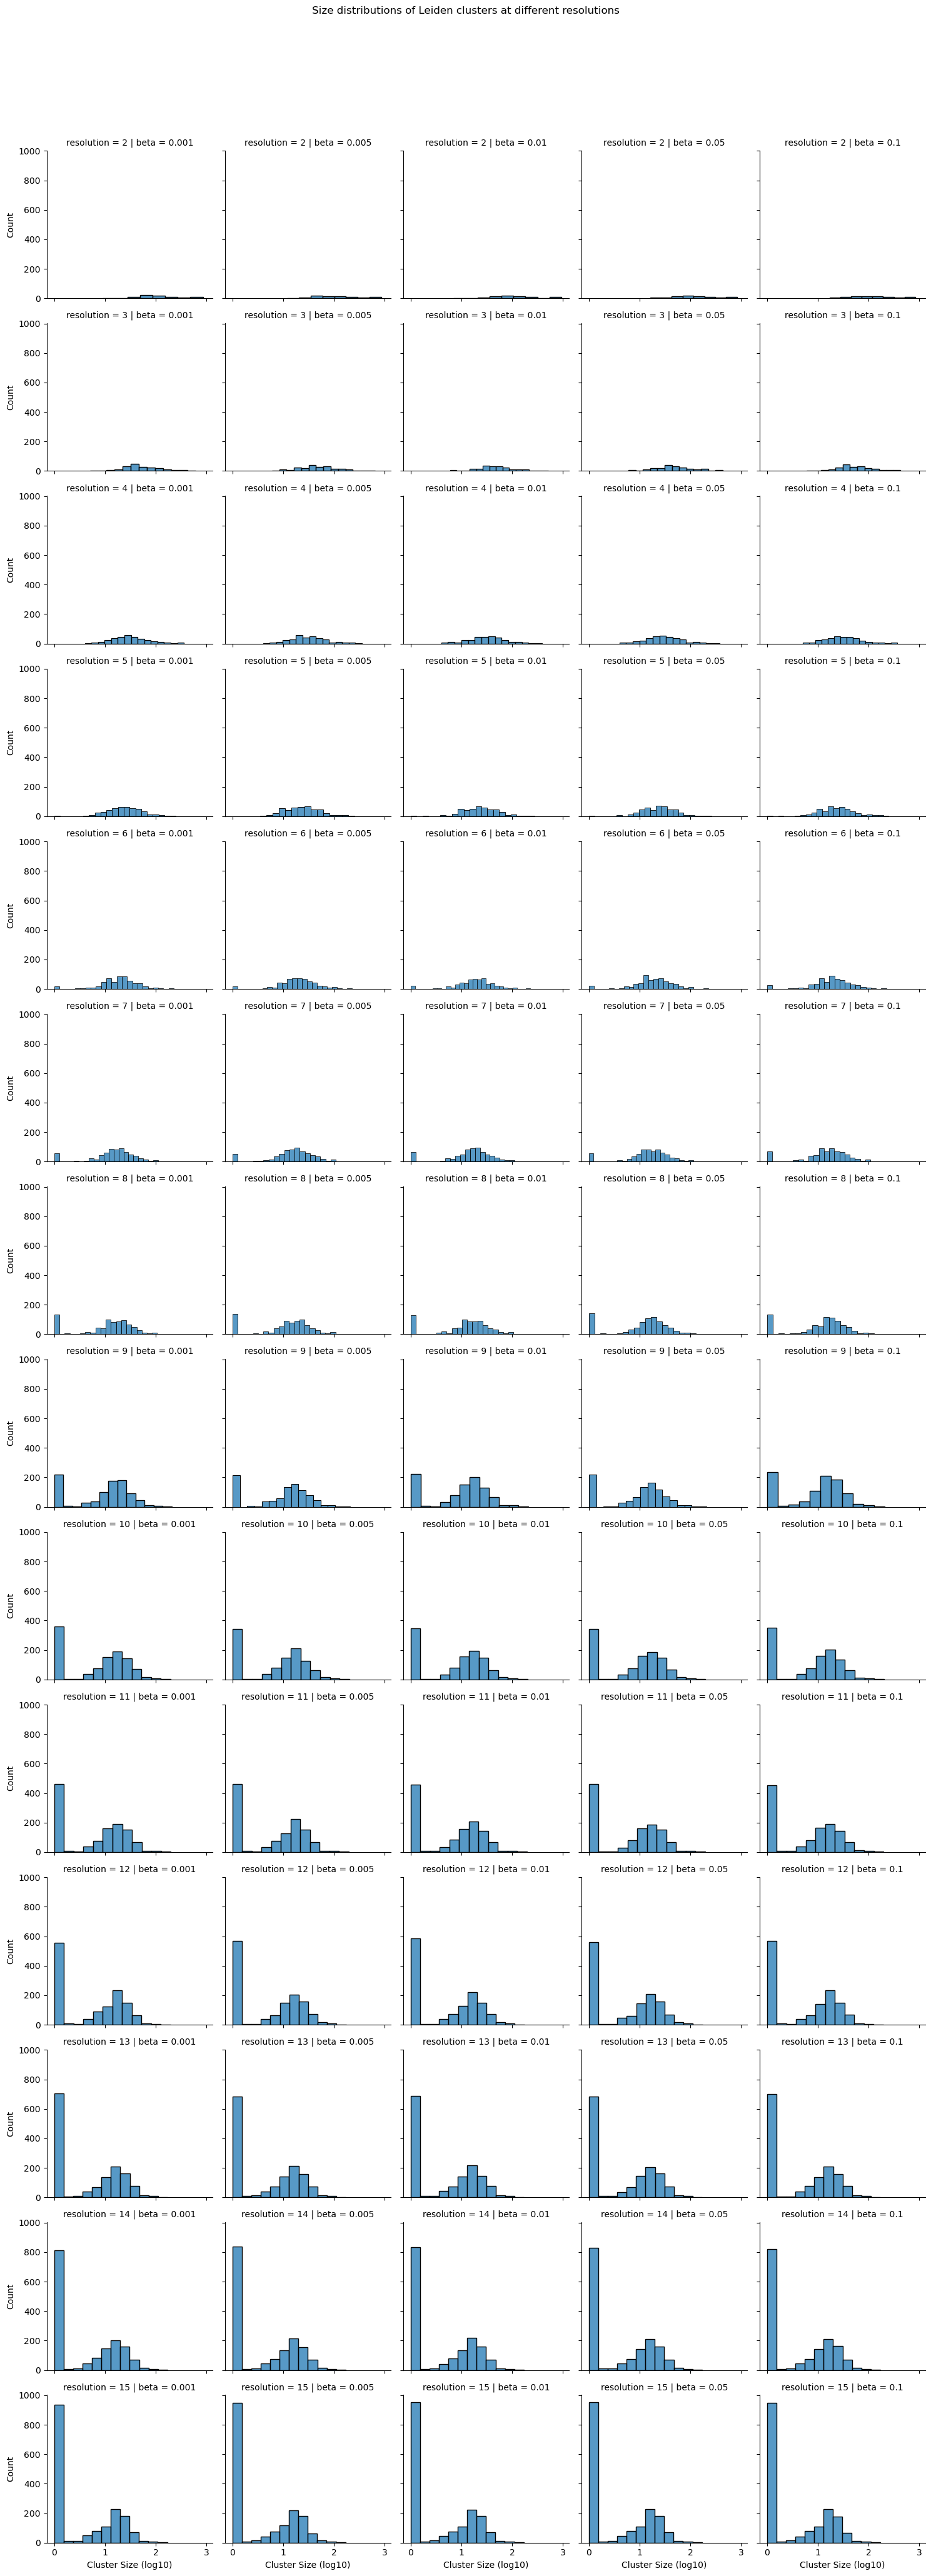

In [55]:
fig1 = sns.FacetGrid(distributions_df, row='resolution',col='beta')
fig1.map(sns.histplot, 'size')
fig1.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
fig1.figure.subplots_adjust(top=0.925)
fig1.set_xlabels('Cluster Size (log10)')
for ax in fig1.axes.flat:
    ax.text(0.85, 0.85, ax)

# fig2 = sns.FacetGrid(distributions_df_filt, row='resolution',col='beta')
# fig2.map(sns.histplot, 'size')
# fig2.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
# fig2.figure.subplots_adjust(top=0.925)
# fig2.set_xlabels('Cluster Size (log10)')

#fig.savefig('./images/grid_leiden_2_5_001_05_msigdbcgp.png')

In [ ]:
from scipy.stats import kstest

base = msigdb_c6_dict
base_distribution = [log(len(gene_set), 10) for gene_set in base.values() if len(gene_set) != 0] 
ks_test_results_df = pd.DataFrame()
distribution = distributions_df
for res in distribution['resolution'].unique():
    for beta in distribution['beta'].unique():
        sizes = distribution[((distribution['resolution'] == res) & (distribution['beta'] == beta))]['size']
        test_p = kstest(sizes, base_distribution).pvalue
        ks_test_results_df = pd.concat([ks_test_results_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'p_value': [test_p]})])

print(ks_test_results_df[ks_test_results_df['pvalue'] > 0.05])

Empty DataFrame
Columns: [resolution, beta, p_value]
Index: []


435.99999999999983
1.0


Text(0.5, 23.52222222222222, 'Cluster Size (log10)')

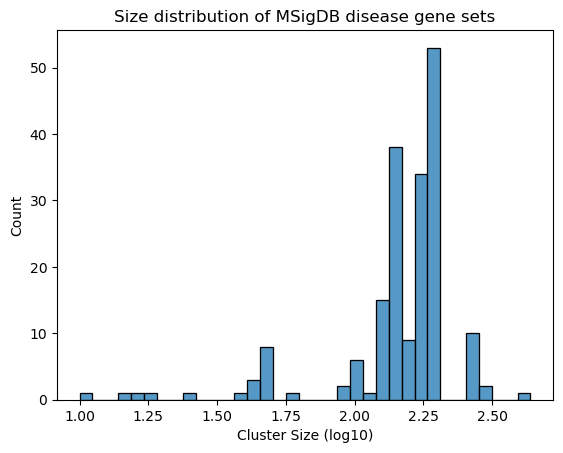

In [ ]:
set_sizes = [log(len(gene_set), 10) for gene_set in msigdb_c6_dict.values() if len(gene_set) != 0] 
fig = sns.histplot(set_sizes)
fig.set_title("Size distribution of MSigDB disease gene sets")
fig.get_figure().savefig("helloo.png")
fig.set_xlabel("Cluster Size (log10)")

In [39]:

threshold = 0.01

def calculate_CCS(enrichment_dict, threshold=0.01):
    CCS_df = pd.DataFrame()

    for (res, betas) in enrichment_dict.items():
        for (beta, cluster_enrichments) in betas.items():
            enriched = [cluster[0][cluster[0]['FDR'] < threshold] for cluster in cluster_enrichments[0].values()]
            n_enriched_clusters = len(enriched)
            if n_enriched_clusters == 0:
                CCS_df = pd.concat([CCS_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'CCS': [0]})])
                continue
            enriched_df = pd.concat(enriched)
            avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
            avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
            CCS = avg_set_per_cluster / avg_cluster_per_set
            CCS_df = pd.concat([CCS_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'avg_s/c': avg_set_per_cluster, 'avg_c/s':avg_cluster_per_set, 'CCS': [CCS]})])
    return CCS_df
            

CCSs = calculate_CCS(msigdb_c2_cgp_clust)

In [62]:
CCSs[(CCSs['CCS'] < 1.5) & (CCSs['CCS'] > 0.5)].sort_values('CCS', ascending=False) # calc best by taking min of addition of diff avgs and (target CCS - 1)

,resolution,beta,avg_s/c,avg_c/s,CCS
0,4,0.005,1.625000,1.216895,1.335366
0,4,0.001,1.611446,1.218679,1.322289
0,4,0.010,1.922118,1.472554,1.305296
0,4,0.050,1.602410,1.281928,1.250000
0,4,0.100,1.757576,1.479592,1.187879
0,5,0.010,1.258278,1.425000,0.883002
0,5,0.001,1.113537,1.370968,0.812227
0,5,0.005,1.028446,1.287671,0.798687
0,5,0.050,1.053648,1.323450,0.796137
0,5,0.100,1.006565,1.321839,0.761488


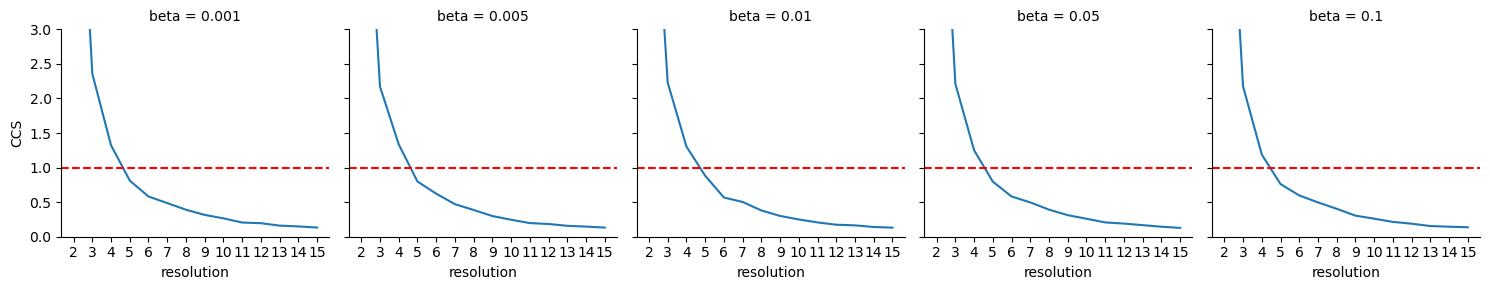

In [38]:
fig = sns.FacetGrid(CCSs, col='beta')
fig.map(sns.lineplot, 'resolution', 'CCS')
fig.set(xticks=CCSs['resolution'].unique())
fig.set(ybound=[0,3])
fig.refline(y=1, color='red')

In [3]:
msigdb_c2_cgp_dict = open_pickle('msigdb_c2_cgp_dict.pkl')
msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')

18126
821
15.0


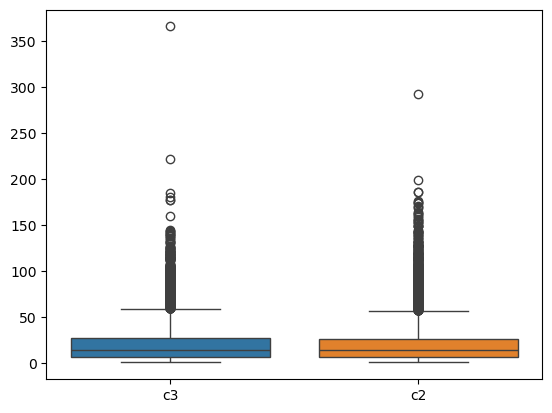

In [32]:
# investigate dataset overlap - number of times that each gene appears in all gene sets
import matplotlib.pyplot as plt


genes = pd.Series([str(gene) for gene_set in msigdb_c3_tft_dict.values() for gene in gene_set])
gene_freqs = genes.value_counts(normalize=False)
genes = pd.Series([str(gene) for gene_set in msigdb_c2_cgp_dict.values() for gene in gene_set])
gene_freqs2 = genes.value_counts(normalize=False)



fig = sns.boxplot(pd.DataFrame({'c3': gene_freqs, 'c2': gene_freqs2}))

upper_c3 = gene_freqs.mean() + 2*gene_freqs.std()
print(len(gene_freqs))
print(len(gene_freqs.where(gene_freqs > upper_c3).dropna()))
print(gene_freqs.median())